## AGN DCR FoM

<br>**Author(s):** Weixiang Yu & Gordon Richards
<br>**Last updated:** 08-26-20
<br>**Short description:** This notebook trys to identify the slopes that we should use to define the final AGN DCR metric and begin identifying a FoM normalized by the baseline cadence. The data used in this notebook has been produced ahead of time where the data is stored in a shared volume 'LSST_MAF'

### 0. Software Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os

mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
                '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

Import the sims_maf modules needed.

In [3]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# import convenience functions
from opsimUtils import *

## 1. Load data from disk

In [4]:
dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/'
outDir = '/home/idies/workspace/Temporary/ywx649999311/LSST_MAF/wy/DCR/0820/ResultDBs/'
metricDataPath = '/home/idies/workspace/Temporary/ywx649999311/LSST_MAF/wy/DCR/0820/MetricData/'

for path in [outDir, metricDataPath]:
    if not os.path.exists(os.path.abspath(path)):
        os.makedirs(os.path.abspath(path))

In [5]:
# import metric evaluations
bundleDicts = {}
resultDbPath = outDir

resultDbsView = getResultsDbs(resultDbPath)
for runName in resultDbsView:
    bundleDicts[runName] = bundleDictFromDisk(resultDbsView[runName], runName, metricDataPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

In [6]:
# Check keys
dbRuns = list(resultDbsView.keys())
bd_keys = list(bundleDicts[dbRuns[1]].keys())
print(bd_keys)

[(1, 'DCR_24.55_g_6m'), (2, 'DCR_23.61_u_6m'), (3, 'DCR_23.61_u_10yr'), (4, 'DCR_24.55_g_10yr')]


### 1.2 Plot the fraction of healpix bins having 3 $\sigma$ SNR as a fucntion of AGN slope
- Plot metric evaluated using the full 10 years survey
- plot metric evaluated using the first 6 months of data
- pick points that are relatively linear on the below plots for next step

In [7]:
# function to compute the fraction given the metric data, desired slope and 
# SNR threshold
def get_frac(data, slope, snr):
    return np.sum(slope/data > snr)/len(data)

In [8]:
m5_medians = {'u': 23.606341961685, 'g': 24.553850201752283}
dcrBundleDict = bundleDicts['baseline_v1.5_10yrs']

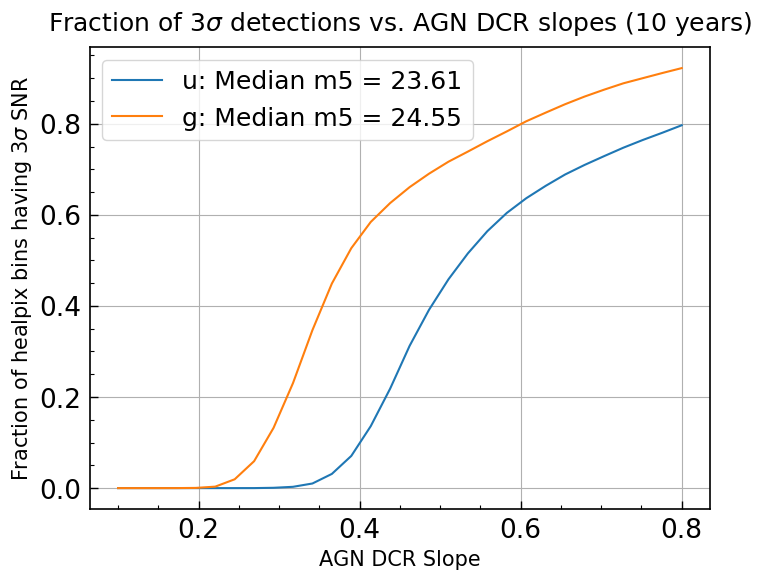

In [9]:
# plot 10 years
slopes_10yr = np.linspace(0.1, 0.8, 30)

for band in ['u', 'g']:
    keys = [*dcrBundleDict.keys()]
    key = [key for key in keys if key[1] == f'DCR_{m5_medians[band]:.2f}_{band}_10yr'][0]
    mask = dcrBundleDict[key].metricValues.mask
    data = dcrBundleDict[key].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    fracs = [get_frac(data, slope, 3) for slope in slopes_10yr]
    plt.plot(slopes_10yr, fracs, label=f'{band.lower()}: Median m5 = {m5_medians[band]:.2f}')
    plt.xlabel('AGN DCR Slope', fontsize=15)
    plt.ylabel('Fraction of healpix bins having 3$\sigma$ SNR', fontsize=15)
    plt.title('Fraction of 3$\sigma$ detections vs. AGN DCR slopes (10 years)', fontsize=18)
    plt.legend(fontsize=18)
    plt.grid(True)

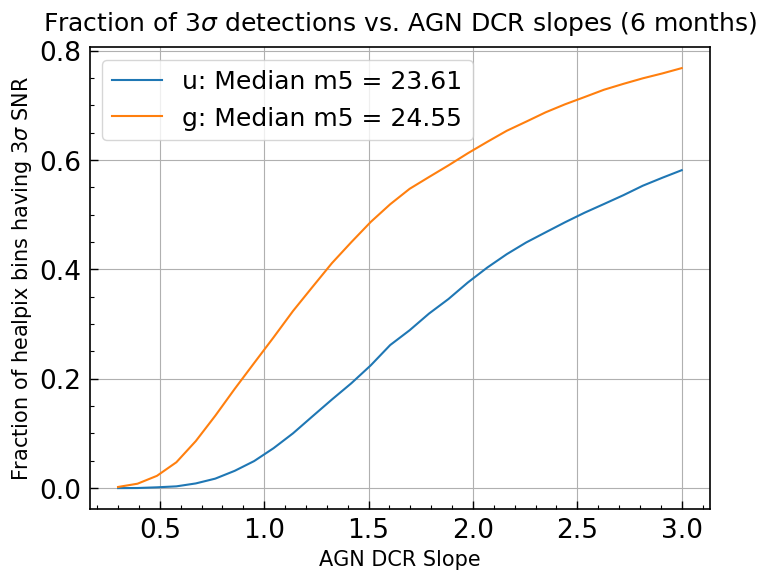

In [10]:
# plot 6 months metric
slopes_6m = np.linspace(0.3, 3, 30)

for band in ['u', 'g']:
    keys = [*dcrBundleDict.keys()]
    key = [key for key in keys if key[1] == f'DCR_{m5_medians[band]:.2f}_{band}_6m'][0]
    mask = dcrBundleDict[key].metricValues.mask
    data = dcrBundleDict[key].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    fracs = [get_frac(data, slope, 3) for slope in slopes_6m]
    plt.plot(slopes_6m, fracs, label=f'{band.lower()}: Median m5 = {m5_medians[band]:.2f}')
    plt.xlabel('AGN DCR Slope', fontsize=15)
    plt.ylabel('Fraction of healpix bins having 3$\sigma$ SNR', fontsize=15)
    plt.title('Fraction of 3$\sigma$ detections vs. AGN DCR slopes (6 months)', fontsize=18)
    plt.legend(fontsize=18)
    plt.grid(True)

### 2. Compute DCR Statistics (Fraction above 3 sigma SNR)
- try 0.45 for 'u' slope and 0.33 for 'g' slope at 10 yrs
- try 1.5 for 'u' slope and 1 for 'g' slope at 6 months

In [11]:
# put v1.5 runs into a dataframe and assign associated family
dbFamil = [run.split('_')[0] for run in dbRuns]
dfRuns = pd.DataFrame({'run':dbRuns, \
                       'runFamil':dbFamil}).sort_values(by='runFamil').reset_index(drop=True)

#### 2.1 Compute statistic for 10 years

In [12]:
# new df, add place holder for frac
dfDCR_stat = dfRuns.copy()
dfDCR_stat['u_frac_10yr'] = 0.0
dfDCR_stat['g_frac_10yr'] = 0.0

# slopes for computing SNR
slopes_10yr = {'u':0.45, 'g':0.33}

In [13]:
# compute actual fraction
for i, run in enumerate(dfDCR_stat['run']):
    # get bd for run
    bundleDict = bundleDicts[run]

    # loop over slope precision to get frac above 3 sigma
    for band in ['u', 'g']:
        keys = [*bundleDict.keys()]
        key = [key for key in keys if key[1] == f'DCR_{m5_medians[band]:.2f}_{band}_10yr'][0]
        mask = bundleDict[key].metricValues.mask
        data = bundleDict[key].metricValues.data[~mask]
        data = data[~(np.isnan(data) | np.isinf(data))]
        frac = get_frac(data, slopes_10yr[band], 3)
        dfDCR_stat.at[i, f'{band}_frac_10yr'] = frac

In [14]:
# compute relative fraction w.r.t baseline_v1.5
baseline_idx = dfDCR_stat.index[(dfDCR_stat.run == 'baseline_v1.5_10yrs')].tolist()[0]
dfDCR_stat['u_frac_10yr_rel'] = dfDCR_stat['u_frac_10yr']/dfDCR_stat.at[baseline_idx, 'u_frac_10yr']
dfDCR_stat['g_frac_10yr_rel'] = dfDCR_stat['g_frac_10yr']/dfDCR_stat.at[baseline_idx, 'g_frac_10yr']

#### 2.1 Compute statistic for 6 months

In [15]:
# new df, add place holder for frac
dfDCR_stat['u_frac_6m'] = 0.0
dfDCR_stat['g_frac_6m'] = 0.0

# slopes for computing SNR
slopes_6m = {'u':1.5, 'g':1.0}

In [16]:
# compute actual fraction
for i, run in enumerate(dfDCR_stat['run']):
    # get bd for run
    bundleDict = bundleDicts[run]

    # loop over slope precision to get frac above 3 sigma
    for band in ['u', 'g']:
        keys = [*bundleDict.keys()]
        key = [key for key in keys if key[1] == f'DCR_{m5_medians[band]:.2f}_{band}_6m'][0]
        mask = bundleDict[key].metricValues.mask
        data = bundleDict[key].metricValues.data[~mask]
        data = data[~(np.isnan(data) | np.isinf(data))]
        frac = get_frac(data, slopes_6m[band], 3)
        dfDCR_stat.at[i, f'{band}_frac_6m'] = frac

In [17]:
# compute relative fraction w.r.t baseline_v1.5
baseline_idx = dfDCR_stat.index[(dfDCR_stat.run == 'baseline_v1.5_10yrs')].tolist()[0]
dfDCR_stat['u_frac_6m_rel'] = dfDCR_stat['u_frac_6m']/dfDCR_stat.at[baseline_idx, 'u_frac_6m']
dfDCR_stat['g_frac_6m_rel'] = dfDCR_stat['g_frac_6m']/dfDCR_stat.at[baseline_idx, 'g_frac_6m']

### 2. Plot normalized DCR 3 $\sigma$ fraction
- One run from each family
- Look at the `filterdist` family in detail
- Look at the `alt` family in detail

#### 2.1 One opsim from each family

In [18]:
# pick on run from each family, note barh plot starts from bottom so ascending
dfFamily = dfDCR_stat.drop_duplicates(subset=['runFamil']).reset_index(drop=True)
dfFamily = dfFamily.sort_values(by='g_frac_10yr_rel', ascending=True).reset_index(drop=True)

In [19]:
def plotbarh(df, cols):
    stats_size = len(cols)
    y = np.arange(len(df))
    width = 0.5/stats_size

    # compute fig size
    fig_y = len(df)*0.8
    fig, ax = plt.subplots(figsize=(12, fig_y))

    for i in range(stats_size):

        if stats_size == 1:
            shift = 0
        else:
            shift = -width/2 + i*width/(stats_size-1)

        summaryValues = df[cols[i]].values
        ax.barh(y+shift, summaryValues, width, label=cols[i])
    
    ax.set_yticks(y)
    ax.set_yticklabels(df['run'].values)

    plt.legend(loc='best')
    plt.xlabel('Normalized fraction')

Text(0.5, 1.0, 'Normalized fraction for 10 yrs DCR')

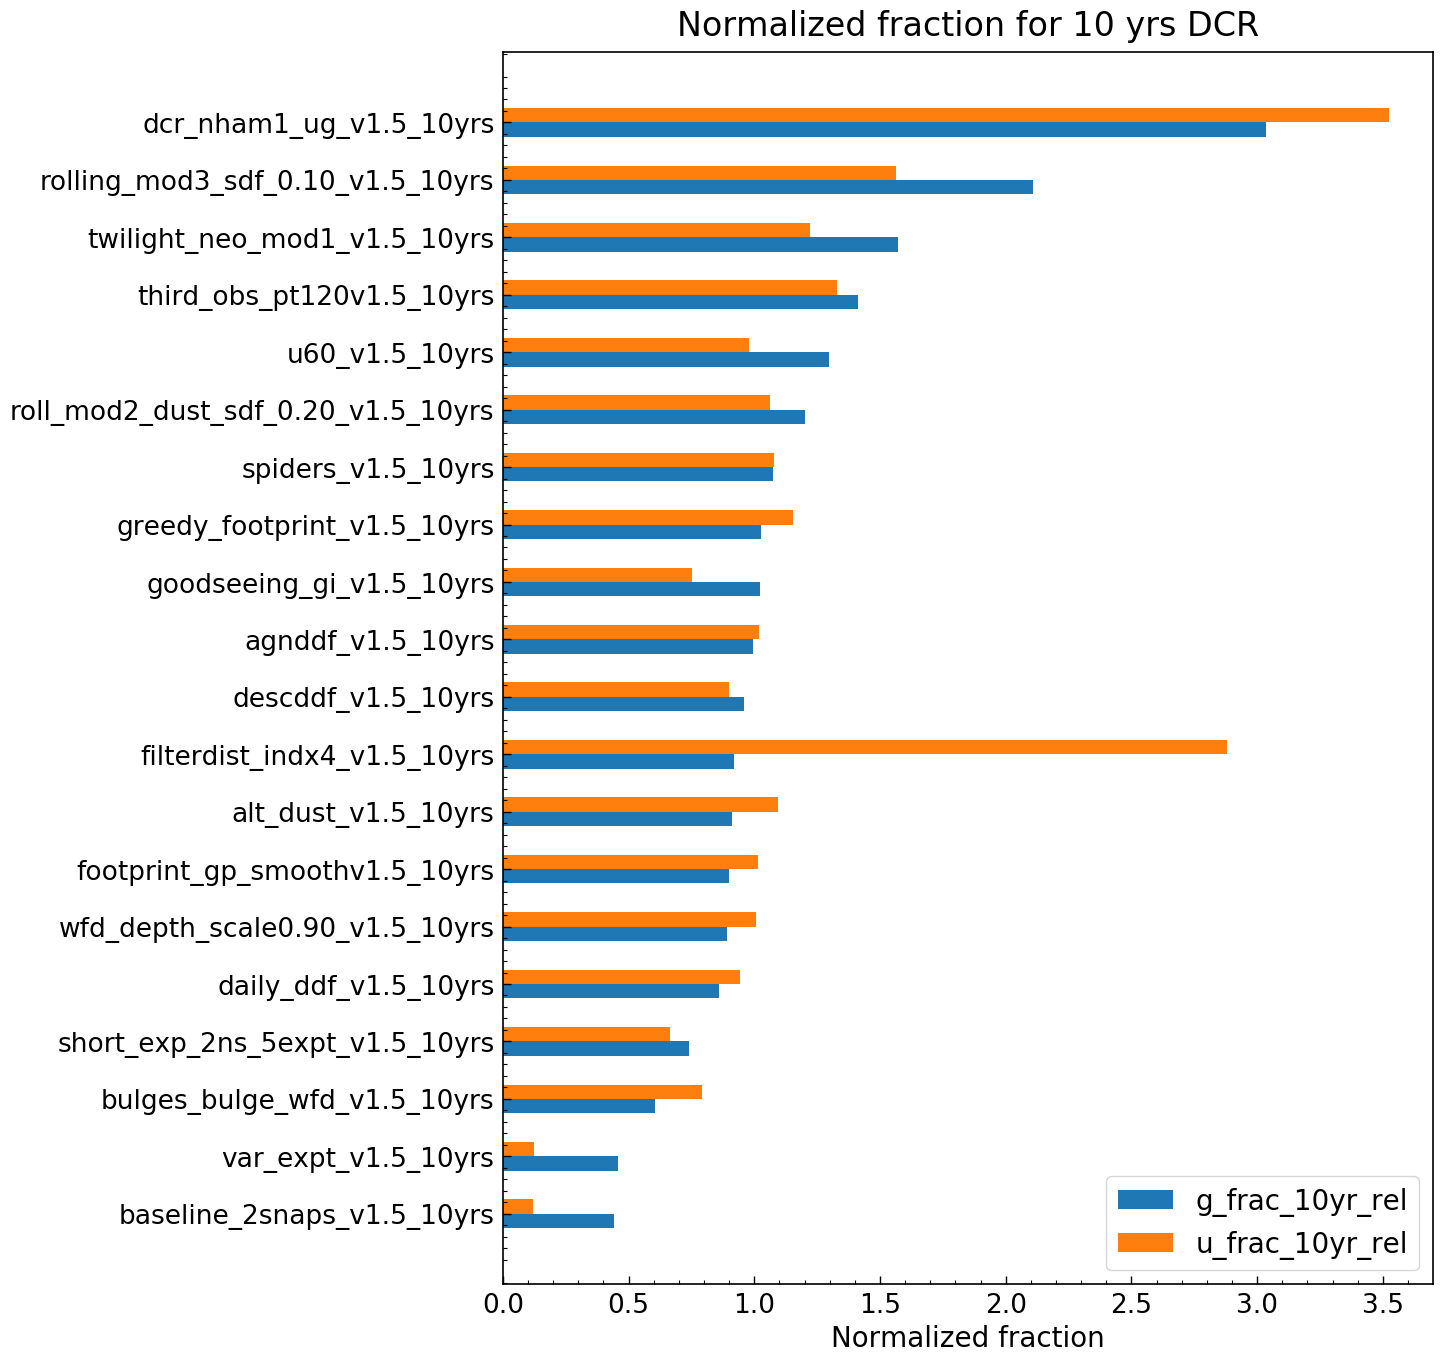

In [20]:
plotbarh(dfFamily, ['g_frac_10yr_rel', 'u_frac_10yr_rel'])
plt.title('Normalized fraction for 10 yrs DCR')

Text(0.5, 1.0, 'Normalized fraction for 6 months DCR')

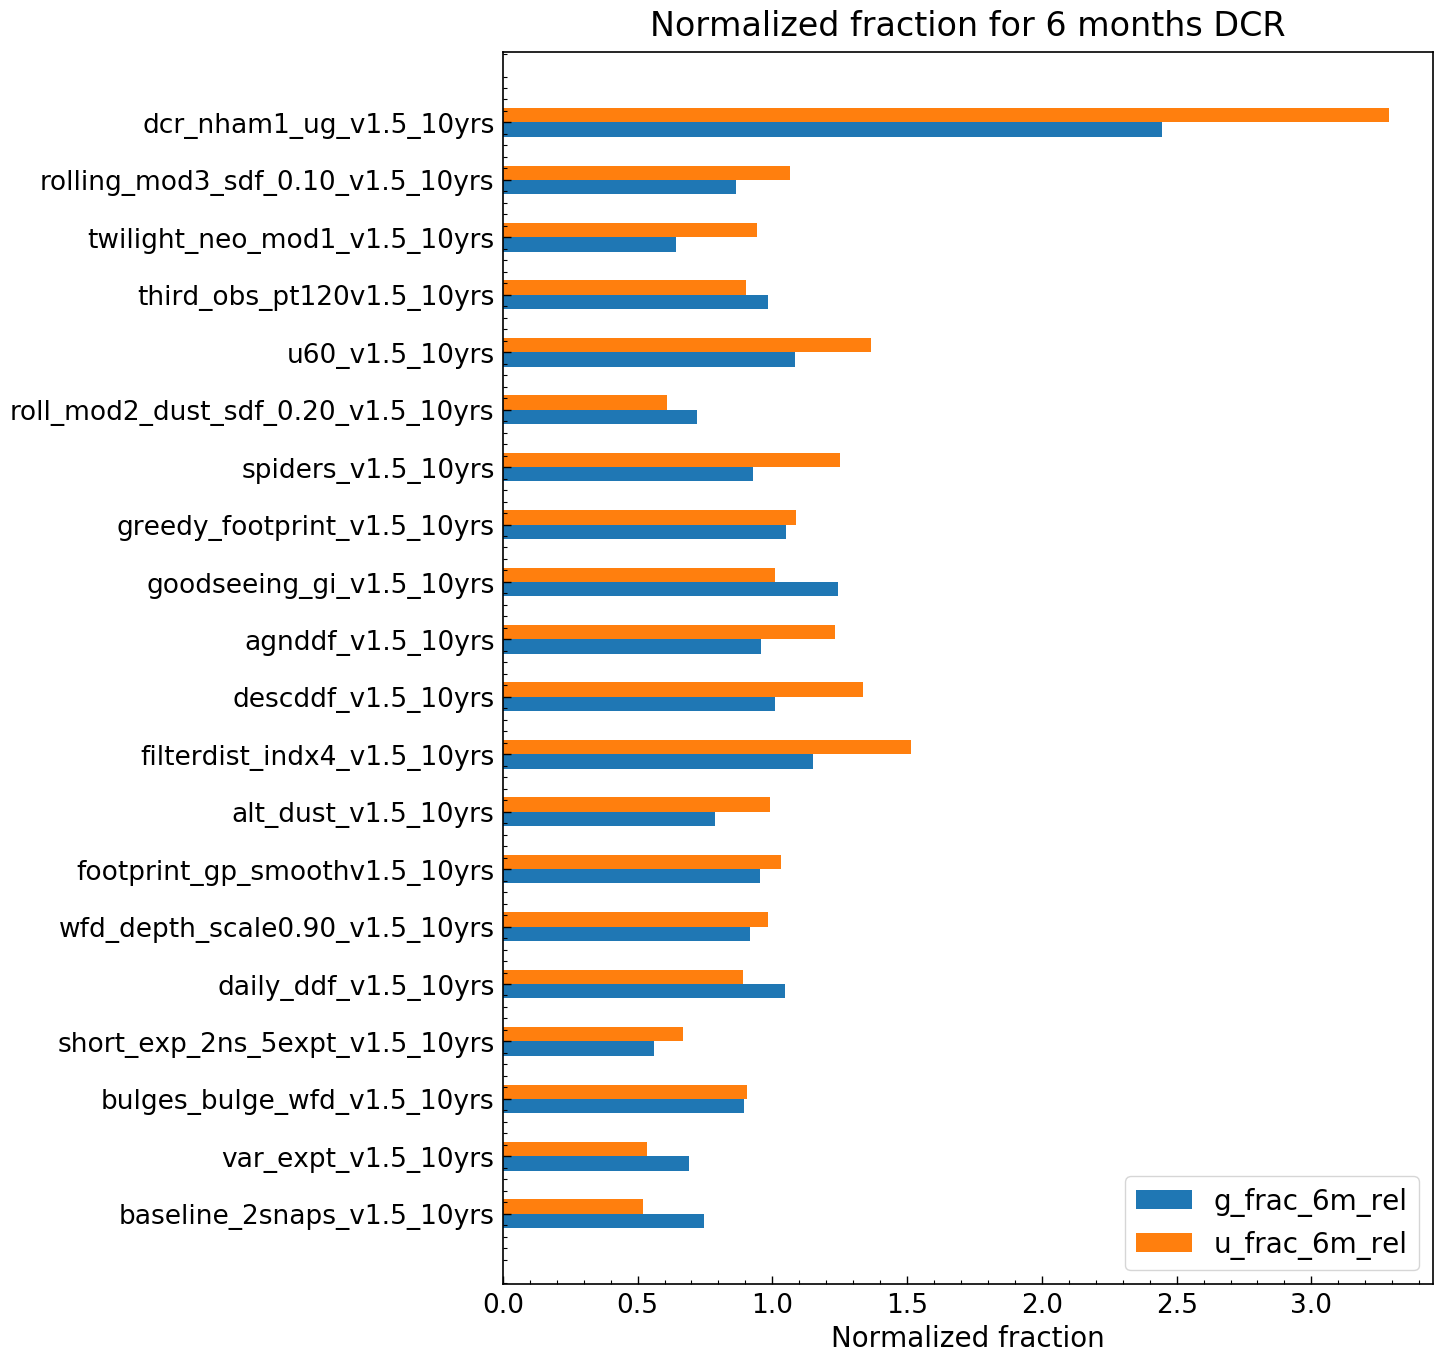

In [21]:
plotbarh(dfFamily, ['g_frac_6m_rel', 'u_frac_6m_rel'])
plt.title('Normalized fraction for 6 months DCR')

#### 2.1 Closer look at the `filterdist` family

The table below displays the filter weights in each opsim run in this family. You can use the 'index' column to locate the corresponding run. That is the opsim run is named as 'filterdist_{index}\_v1.5_10yrs'

\begin{array}{lrrrrrr}
\text { Name } & \text{Index} & u & g & r & i & z & y \\
\hline \text { Uniform } & {indx1} & 1.00 & 1.00 & 1 & 1.00 & 1.00 & 1.00 \\
\text { Baseline } & {indx2} & 0.31 & 0.44 & 1 & 1.00 & 0.90 & 0.90 \\
g \text { heavy } & {indx3} & 0.31 & 1.00 & 1 & 1.00 & 0.90 & 0.90 \\
u \text { heavy } & {indx4} & 0.90 & 0.44 & 1 & 1.00 & 0.90 & 0.90 \\
z \text { and } y \text { heavy } & {indx5} & 0.31 & 0.44 & 1 & 1.00 & 1.50 & 1.50 \\
i \text { heavy } & {indx6} & 0.31 & 0.44 & 1 & 1.50 & 0.90 & 0.90 \\
\text { Bluer } & {indx7} & 0.50 & 0.60 & 1 & 1.00 & 0.90 & 0.90 \\
\text { Redder } & {indx8} & 0.31 & 0.44 & 1 & 1.10 & 1.10 & 1.10 \\
\hline
\end{array}

In [22]:
# get the runs in this family
df_fd = dfDCR_stat[dfDCR_stat.runFamil == 'filterdist'].sort_values(
    by='g_frac_10yr_rel').reset_index(drop=True)

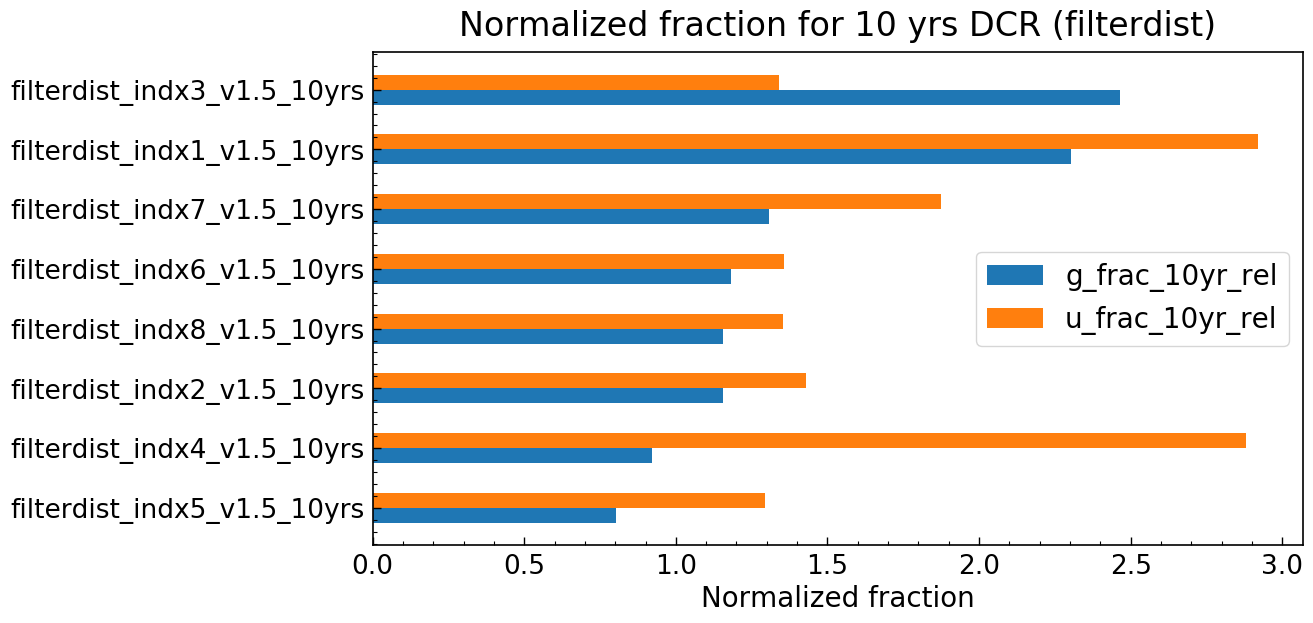

In [23]:
# plot 10 yrs DCR FoM
plotbarh(df_fd, ['g_frac_10yr_rel', 'u_frac_10yr_rel'])
_ = plt.title('Normalized fraction for 10 yrs DCR (filterdist)')

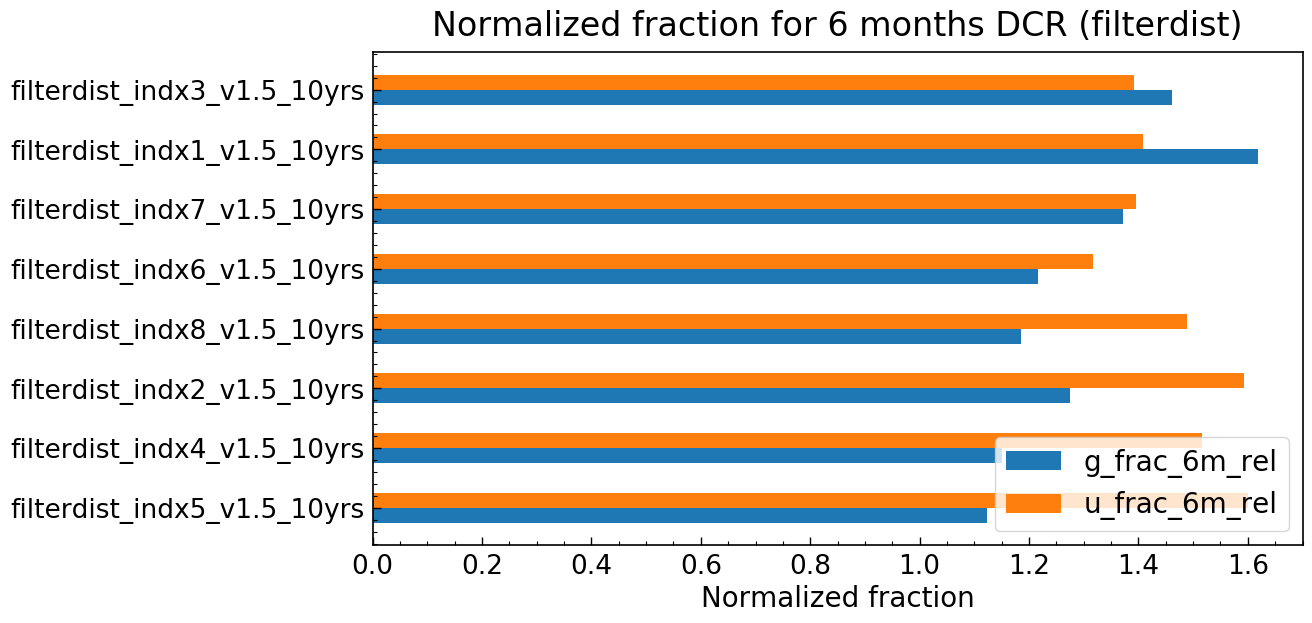

In [24]:
# plot 6 months DCR FoM
plotbarh(df_fd, ['g_frac_6m_rel', 'u_frac_6m_rel'])
_ = plt.title('Normalized fraction for 6 months DCR (filterdist)')

#### 2.1 Closer look at the `alt_roll` family
There are only two variants of the `alt` strategy, one with two dec bands plus N/S alternation (alt_roll_mod2) and another without the dec bands but still alternates between north and south. 

In [25]:
# get the runs in this family
df_alt = dfDCR_stat[dfDCR_stat.runFamil == 'alt'].sort_values(
    by='g_frac_10yr_rel').reset_index(drop=True)

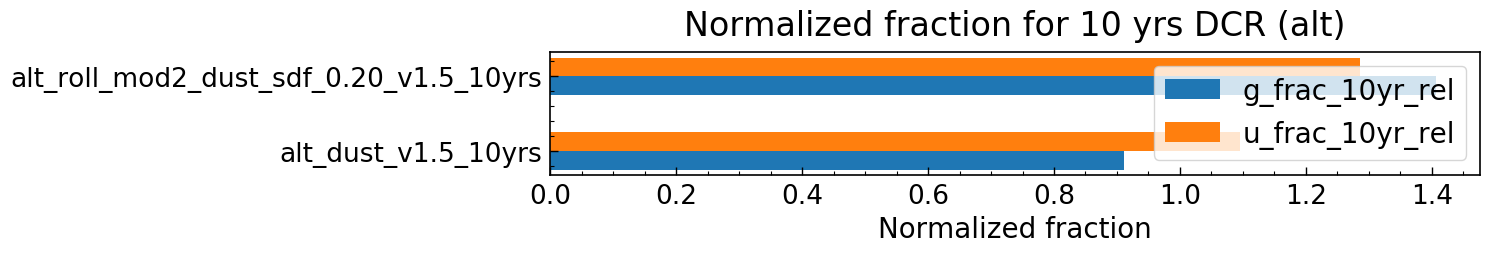

In [26]:
# plot 10 yrs DCR FoM
plotbarh(df_alt, ['g_frac_10yr_rel', 'u_frac_10yr_rel'])
_ = plt.title('Normalized fraction for 10 yrs DCR (alt)')

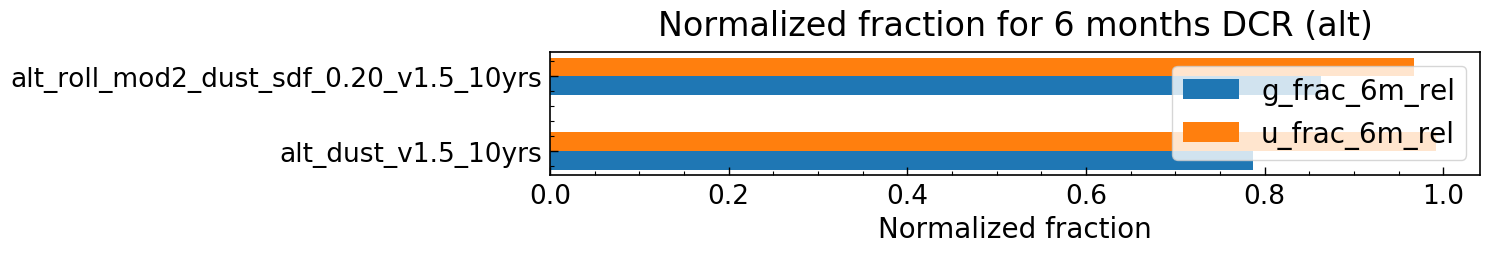

In [27]:
# plot 6 months DCR FoM
plotbarh(df_alt, ['g_frac_6m_rel', 'u_frac_6m_rel'])
_ = plt.title('Normalized fraction for 6 months DCR (alt)')